In [1]:
import simpy
import random
import numpy as np
import matplotlib.pyplot as plt

In [12]:
# Parámetros de la simulación
TIEMPO_SIMULACION = 100
TASA_LLEGADAS = 1/5      # una llegada cada 5 unidades de tiempo
TASA_SERVICIO = 1/4      # el servidor atiende en promedio cada 4 unidades de tiempo
NUM_SERVIDORES = 1       # Número de servidores (K en M/M/K/K)

# Arrays de tiempos de llegada y servicio
tiempos_llegada = [1,2,3,7,2,3,8,0,5] # Tiempos entre llegadas
tiempos_servicio = [9,1,4,1,1,5,3,8,2]  # Tiempos de servicio

# Variables para análisis
tiempos_espera = []
clientes_bloqueados = 0
total_clientes = 0

In [13]:
def cliente(env, nombre, servidor, tiempo_servicio):
    global clientes_bloqueados, total_clientes
    llegada = env.now
    total_clientes += 1
    print(f"{nombre} llega en el tiempo {llegada:.2f}")
    
    # Verificar si hay capacidad en el servidor
    if servidor.count < servidor.capacity:
        with servidor.request() as req:
            yield req
            espera = env.now - llegada
            tiempos_espera.append(espera)
            print(f"{nombre} empieza a ser atendido en {env.now:.2f} (esperó {espera:.2f})")
            
            #tiempo_servicio = random.expovariate(TASA_SERVICIO)
            yield env.timeout(tiempo_servicio)
            print(f"{nombre} termina en {env.now:.2f}")
    else:
        clientes_bloqueados += 1
        print(f"{nombre} es bloqueado en el tiempo {llegada:.2f} (servidor lleno)")

In [14]:
#def generador_clientes(env, servidor):
#    i = 0
#    while True:
#        yield env.timeout(random.expovariate(TASA_LLEGADAS))
#        i += 1
#        env.process(cliente(env, f"Cliente {i}", servidor))
def generador_clientes(env, servidor, tiempos_llegada, tiempos_servicio):
    i = 0
    for tiempo_llegada, tiempo_servicio in zip(tiempos_llegada, tiempos_servicio):
        yield env.timeout(tiempo_llegada)
        i += 1
        env.process(cliente(env, f"Cliente {i}", servidor, tiempo_servicio))

In [15]:

def erlang_b(K, A):
    """Modelo Erlang B para M/M/K/K"""
    B = 1.0
    for k in range(1, K + 1):
        B = (A * B) / (k + A * B)
    return B

Cliente 1 llega en el tiempo 1.00
Cliente 1 empieza a ser atendido en 1.00 (esperó 0.00)
Cliente 2 llega en el tiempo 3.00
Cliente 2 es bloqueado en el tiempo 3.00 (servidor lleno)
Cliente 3 llega en el tiempo 6.00
Cliente 3 es bloqueado en el tiempo 6.00 (servidor lleno)
Cliente 1 termina en 10.00
Cliente 4 llega en el tiempo 13.00
Cliente 4 empieza a ser atendido en 13.00 (esperó 0.00)
Cliente 4 termina en 14.00
Cliente 5 llega en el tiempo 15.00
Cliente 5 empieza a ser atendido en 15.00 (esperó 0.00)
Cliente 5 termina en 16.00
Cliente 6 llega en el tiempo 18.00
Cliente 6 empieza a ser atendido en 18.00 (esperó 0.00)
Cliente 6 termina en 23.00
Cliente 7 llega en el tiempo 26.00
Cliente 8 llega en el tiempo 26.00
Cliente 8 es bloqueado en el tiempo 26.00 (servidor lleno)
Cliente 7 empieza a ser atendido en 26.00 (esperó 0.00)
Cliente 7 termina en 29.00
Cliente 9 llega en el tiempo 31.00
Cliente 9 empieza a ser atendido en 31.00 (esperó 0.00)
Cliente 9 termina en 33.00


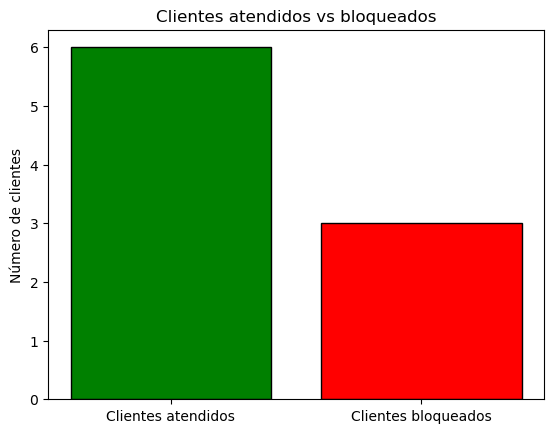


Clientes atendidos: 6
Clientes bloqueados: 3
Probabilidad de bloqueo: 0.33
Tiempo promedio de espera: 0.00 unidades de tiempo
Tasa de llegada (λ): 2.00
Tasa de servicio (μ): 0.26
Tráfico ofrecido: 7.56 Erlangs
Probabilidad de bloqueo (rechazo): 0.8831
Probabilidad de servicio exitoso: 0.1169


In [16]:
# Crear entorno de simulación
env = simpy.Environment()
servidor = simpy.Resource(env, capacity=NUM_SERVIDORES)# k servidores 
#env.process(generador_clientes(env, servidor))
env.process(generador_clientes(env, servidor, tiempos_llegada, tiempos_servicio))
env.run(until=TIEMPO_SIMULACION)

# Calcular probabilidad de bloqueo
probabilidad_bloqueo = clientes_bloqueados / total_clientes


# Representar visualmente la probabilidad de bloqueo
plt.bar(['Clientes atendidos', 'Clientes bloqueados'], 
        [total_clientes - clientes_bloqueados, clientes_bloqueados], 
        color=['green', 'red'], edgecolor='black')
plt.title("Clientes atendidos vs bloqueados")
plt.ylabel("Número de clientes")
plt.show()


# Estadísticas
print(f"\nClientes atendidos: {total_clientes - clientes_bloqueados}")
print(f"Clientes bloqueados: {clientes_bloqueados}")
print(f"Probabilidad de bloqueo: {probabilidad_bloqueo:.2f}")
if tiempos_espera :
    print(f"Tiempo promedio de espera: {sum(tiempos_espera)/len(tiempos_espera):.2f} unidades de tiempo")
else:
    print("No hubo tiempos de espera registrados.")


# 1. Calcular diferencias entre llegadas si son tiempos absolutos
interllegadas = np.diff(tiempos_llegada)  # [1.0, 1.5, 1.5, 1.2]

# 2. Tasa de llegada (lambda) = 1 / tiempo promedio entre llegadas
tasa_llegada = 1 / np.mean(interllegadas)

# 3. Tasa de servicio (mu) = 1 / tiempo promedio de servicio
tasa_servicio = 1 / np.mean(tiempos_servicio)

print(f"Tasa de llegada (λ): {tasa_llegada:.2f}")
print(f"Tasa de servicio (μ): {tasa_servicio:.2f}")    


# Tráfico ofrecido en Erlangs
A = tasa_llegada / tasa_servicio

# Probabilidad de bloqueo (el cliente llega y el único servidor está ocupado)
bloqueo = erlang_b(NUM_SERVIDORES, A)

# Resultados
print(f"Tráfico ofrecido: {A:.2f} Erlangs")
print(f"Probabilidad de bloqueo (rechazo): {bloqueo:.4f}")
print(f"Probabilidad de servicio exitoso: {1 - bloqueo:.4f}")